# Steaming Time Variation Analysis (Steam Generator Limescaling and Descaling)

## Objective
The goal of this project is to analyze the descaling behaviour of devices based on a predefined steaming threshold. 

When a cleaning process is launched on a cooking devices, limescale is being produced in the steam generator. With a predefined steaming threshold and the descaling option selected at cleaning start, a descaling process is triggered in the steam generator once the steaming limit is reached.

## Terms Definition
- DHZ2: Steaming Time 2
- DGEnt: Steam Generator descaling

## Tools & Libraries
- NumPy
- Pandas
- Matplotlib

## Import Libraries
Import the required libraries for data processing and plotting.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

## Define functions
Below are the main functions used for calculating cumulative steaming time, generating visualizations and running simulations.

In [2]:
# Plots cummulative steaming time per device size according to the occurence of descalong or not
def plot_DHZ2_cum(
    df: pd.DataFrame,
    decalc_col: str,
    calc_points_col: str, 
    calc_threshold_col: str, 
    orig_calc_threshold_col: str = None,
    output_filename: str = None,
):
    device_sizes = sorted(df.device_size.unique())

    plt.figure(figsize=(20, 70 / 13 * len(device_sizes)))

    # Calculates the cummulative distribution function according to device sizes
    for i, device_size in enumerate(device_sizes):
        device_pd = df.loc[df.device_size == device_size]
        calc_threshold = device_pd[calc_threshold_col].iloc[0] 
        if orig_calc_threshold_col is not None:
            orig_calc_threshold = device_pd[orig_calc_threshold_col].iloc[0]
        else:
            orig_calc_threshold = None

        bins = np.linspace(0, 100000, 100)
        
        bin_centers = (bins[1:] + bins[:-1]) / 2 

        # Creates a histogram of steaming time when no descaling occured
        no_decalc_hist, _ = np.histogram(
            device_pd.loc[device_pd[decalc_col] == 0][calc_points_col], bins=bins
        ) 

        # Creates a histogram of steaming time when descaling occured
        decalc_hist, _ = np.histogram(
            device_pd.loc[device_pd[decalc_col] == 1][calc_points_col], bins=bins
        )

        # Calculates the cumulative sum of the histograms 
        no_decalc_cum = no_decalc_hist.cumsum() / len(device_pd)
        decalc_cum = decalc_hist.cumsum() / len(device_pd)
        
        decalc_fraction = decalc_cum[-1] 
        
        threshold_value = None

        # Determines the bin center and corresponding descaling value where decsaling starts
        for x, y in zip(bin_centers, decalc_cum):
            if x >= calc_threshold:
                threshold_value = y
                break
        over_threshold_value = decalc_fraction - threshold_value

        if orig_calc_threshold is not None:
            orig_threshold_value = None
            for x, y in zip(bin_centers, decalc_cum):
                if x >= orig_calc_threshold:
                    orig_threshold_value = y
                    break
            over_orig_threshold_value = decalc_fraction - orig_threshold_value

        y_max = 1.0

        plt.subplot(len(device_sizes), 1, i + 1)
        plt.title(device_size)

        centers_under_threshold = bin_centers[bin_centers < (calc_threshold / 2)]  
        no_decalc_cum_under_threshold = no_decalc_cum[: len(centers_under_threshold)] 

        def prefix_list_with_value(data, value):
            return [value] + list(data)

        # Plots descaling instances
        plt.step(
            prefix_list_with_value(
                data=bin_centers,
                value=(bin_centers[0] - (bin_centers[1] - bin_centers[0])), 
            ),
            prefix_list_with_value(data=decalc_cum + no_decalc_cum, value=0), 
            where="mid",
            label="DGEnt=1",
            color=(1.0, 0.4980392156862745, 0.054901960784313725),
            linewidth=3,
        )

        # Plots no descaling instances
        plt.step(
            prefix_list_with_value(
                data=centers_under_threshold,
                value=centers_under_threshold[0] - (centers_under_threshold[1] - centers_under_threshold[0]),
            ),
            prefix_list_with_value(data=no_decalc_cum_under_threshold, value=0),            
            where="mid",
            label="DGEnt=0",
            color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
            linewidth=3,
        )

        # Highlights half of the threshold value on the plot
        plt.vlines(
            calc_threshold / 2, ymin=0, ymax=y_max, color="black", linestyle="dashed",
            label=f"calc threshold / 2={calc_threshold // 2}",
        )
        plt.vlines(
            calc_threshold / 2,
            ymin=1 - decalc_fraction,
            ymax=y_max,
            color="red",
            linestyle="solid",
        )
        plt.text(
            calc_threshold / 2 - 1000,
            1 - 0.5 * decalc_fraction,
            f"{100*decalc_fraction:.0f}%",
            horizontalalignment="right",
            verticalalignment="center",
        )

        # Highlights the threshold value on the plot
        plt.vlines(
            calc_threshold, ymin=0, ymax=y_max, color="black", linestyle="dotted",
            label=f"calc threshold={calc_threshold}",
        )
        plt.vlines(
            calc_threshold,
            ymin=1 - over_threshold_value,
            ymax=y_max,
            color="red",
            linestyle="solid",
        )
        plt.text(
            calc_threshold - 1000,
            1 - over_threshold_value,
            f"{100*over_threshold_value:.0f}%",
            horizontalalignment="right",
            verticalalignment="bottom",
        )

        if orig_calc_threshold is not None and orig_calc_threshold != calc_threshold:
            plt.vlines(
                orig_calc_threshold,
                ymin=0,
                ymax=y_max,
                color="orange",
                linestyle="dotted",
                label=f"original calc threshold={orig_calc_threshold}"
            )
            plt.vlines(
                orig_calc_threshold,
                ymin=1 - over_orig_threshold_value,
                ymax=y_max,
                color="red",
                linestyle="solid",
            )
            plt.text(
                orig_calc_threshold - 1000,
                1 - over_orig_threshold_value,
                f"{100*over_orig_threshold_value:.0f}%",
                horizontalalignment="right",
                verticalalignment="bottom",
            )

        plt.xlabel("DHZ2 value")
        plt.ylabel("percentage of cleanings\n with DHZ2 < x")
        plt.legend(loc="upper right")
        plt.ylim(0, y_max)

        plt.gca().yaxis.set_major_locator(MaxNLocator(10))
        plt.gca().xaxis.set_major_locator(MaxNLocator(15))
        plt.grid()

    plt.tight_layout()
    if output_filename:
        plt.savefig(output_filename)

In [3]:
# Calculate new steaming time based on if threshold is reached or not
def create_simulation(df: pd.DataFrame, calc_points_col: str, calc_points_diff_col: str, calc_threshold_col: str, output_col: str, output_col_DGEnt: str, new_calc_thresold: int = None):

    # Sorts data and remove where no cleaning occcured
    work_df = df.sort_values(by=["serial", "LOGCHARGEDATETIME"])
    work_df = work_df.loc[work_df[calc_points_diff_col].notna()]

    if new_calc_thresold is not None:
        work_df["new_calc_threshold"] = new_calc_thresold
    else:
        work_df["new_calc_threshold"] = work_df["calc_threshold"]

    # Calculates new steaming time for each devices serial number
    def calculate_per_serial(serial_df):
        values = [serial_df.iloc[0][calc_points_col]]
        current_value = values[0]

        for i in range(1, len(serial_df)):
            diff = serial_df.iloc[i][calc_points_diff_col]
            threshold = serial_df.iloc[i]["new_calc_threshold"]

            # Checks if steaming time value is more than half of threshold value
            if serial_df.iloc[i][calc_points_col] > threshold / 2:
                current_value = serial_df.iloc[i][calc_points_col]
                values.append(current_value)
                continue

            if current_value < threshold / 2:
                current_value += diff
            else:
                current_value = diff
                
            values.append(current_value)

        serial_df[output_col] = values
        return serial_df

    #Generate final dataframe with new steaming time based on results from above calculation
    result_df = (
        work_df
            .groupby("serial", group_keys=False)
            .apply(calculate_per_serial)
            .reset_index(drop=True)
    )

    # Checks if new steaming time is above or below half of the threshold limit
    result_df[output_col_DGEnt] = result_df[output_col] > (result_df["new_calc_threshold"] / 2)
    return result_df

# Read data

In [4]:
# Reads data 
df = pd.read_excel("Steaming_data.xlsx", index_col=0)
df

,serial,LOGCHARGEDATETIME,prog_name,ReiProgKategorie,DGEnt,dirt_points,DHZ2,cleaning_group,first_DHZ2,DHzg_active,DHzg,DHZ2_fake,prev_decalc,device_size,calc_threshold,DHZ2_diff,DHzg_active_diff,DHzg_diff,DHZ2_fake_diff
0,2001280,2025-09-01 16:24:34,Média (5-592),2,False,3319,8498,medium,8498,8306,6451.5,8308,0.0,E11,36000,896.0,892.0,730.5,896.0
1,2001280,2025-09-03 16:10:27,Pesada (5-592),3,False,14359,14657,strong,14657,14443,10399.0,14461,0.0,E11,36000,6159.0,6137.0,3947.5,6153.0
2,2001280,2025-09-04 15:29:57,Média (5-592),2,False,2674,16721,medium,16721,16511,11849.5,16525,0.0,E11,36000,2064.0,2068.0,1450.5,2064.0
3,2001280,2025-09-05 15:40:23,Pesada (5-592),3,True,4103,22205,strong,22205,21994,14932.5,22009,0.0,E11,36000,5484.0,5483.0,3083.0,5484.0
4,2001280,2025-09-08 16:14:49,Média (5-592),2,False,2429,187,medium,187,0,0.0,0,1.0,E11,36000,187.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2409316,2025-09-03 20:01:13,Intensywne (5-592),3,False,3931,8154,strong,8154,7904,6377.0,7983,0.0,E11,36000,1268.0,1242.0,935.0,1268.0
4996,2409316,2025-09-04 19:31:36,Intensywne (5-592),3,False,4416,9340,strong,9340,9055,7443.5,9169,0.0,E11,36000,1186.0,1151.0,1066.5,1186.0
4997,2409316,2025-09-05 20:54:12,Intensywne (5-592),3,False,6017,11217,strong,11217,10926,8993.0,11046,0.0,E11,36000,1877.0,1871.0,1549.5,1877.0
4998,2409316,2025-09-06 20:07:26,Intensywne (5-592),3,False,4971,12386,strong,12386,12081,9906.0,12190,0.0,E11,36000,1169.0,1155.0,913.0,1144.0


# Plot DHZ2 cumulative distribution

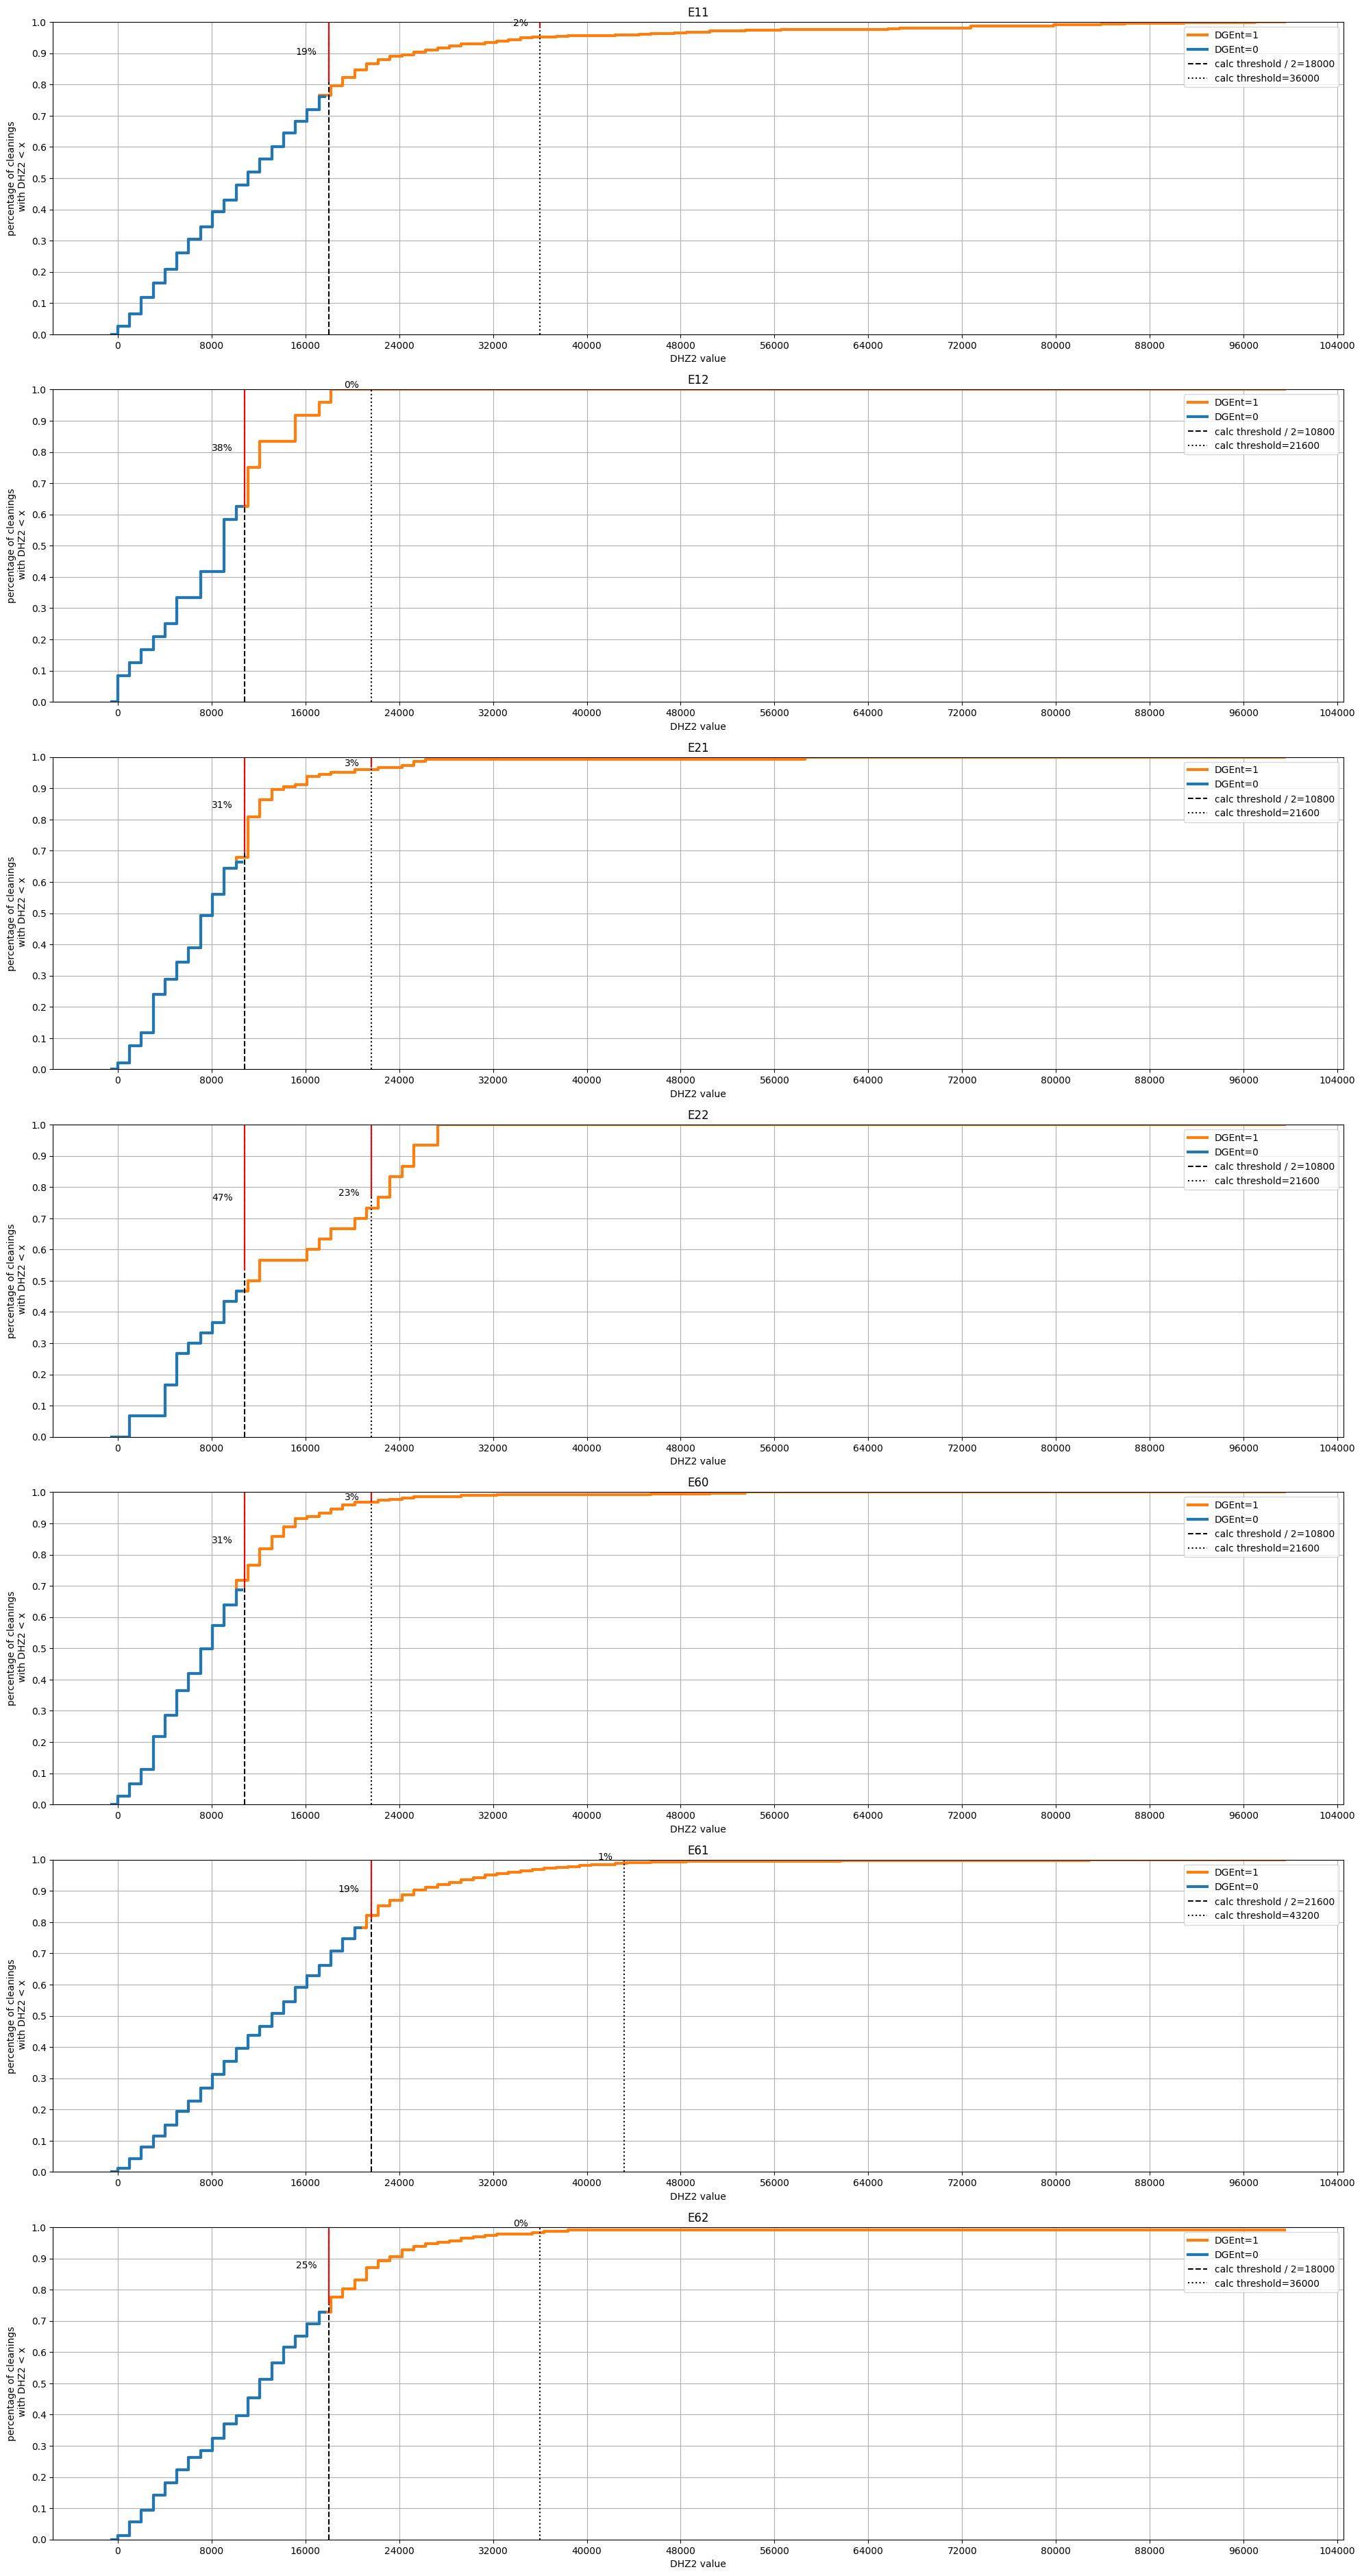

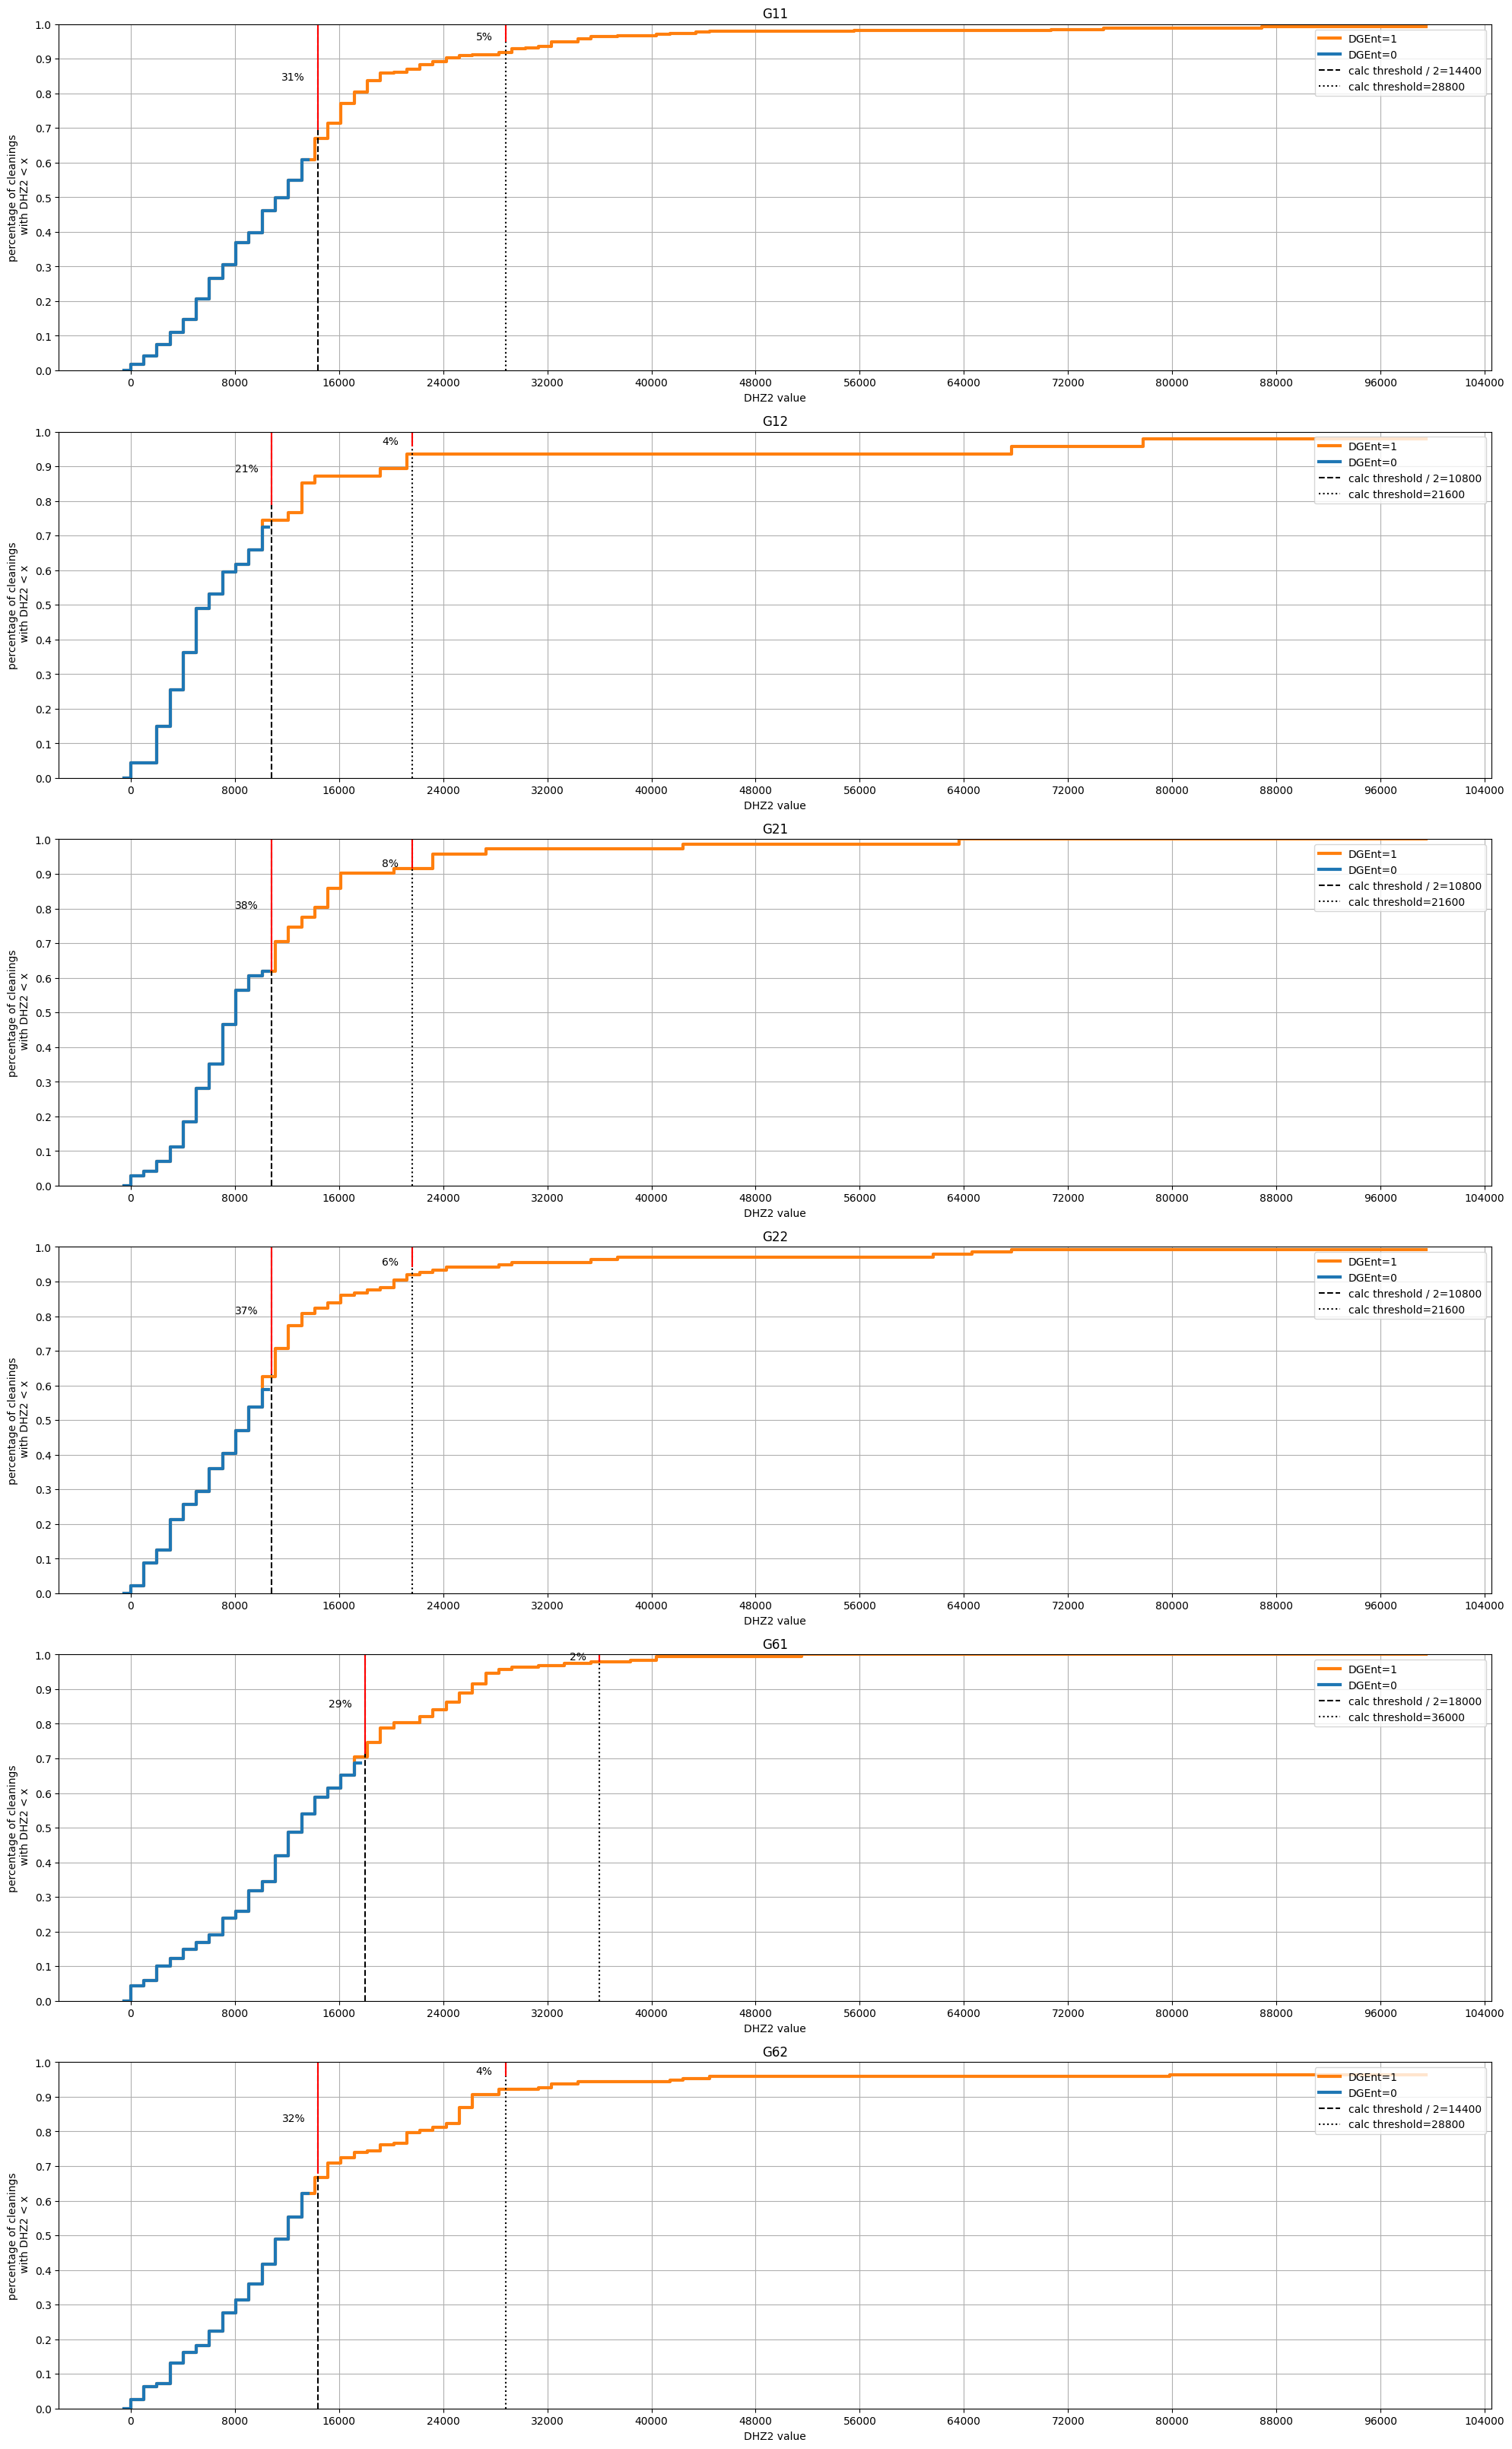

In [5]:
# Plots cumulative distribution function for electrical and gas devices
plot_DHZ2_cum(df=df.loc[df.device_size.str.startswith("E")], decalc_col="DGEnt", calc_points_col="DHZ2", calc_threshold_col="calc_threshold", output_filename="./DHZ2_orig_E.png")
plot_DHZ2_cum(df=df.loc[df.device_size.str.startswith("G")], decalc_col="DGEnt", calc_points_col="DHZ2", calc_threshold_col="calc_threshold", output_filename="./DHZ2_orig_G.png")

### Simulated distribution based on DHZ2

In [6]:
# Generates new dataframe based on steaming time and steaming time difference
simulation_df = create_simulation(df=df, calc_points_col="DHZ2", calc_points_diff_col="DHZ2_diff", calc_threshold_col="calc_threshold", output_col="new_DHZ2", output_col_DGEnt="new_DGEnt")

simulation_df.to_excel("Simulated_DHZ2.xlsx", columns=['serial', 'LOGCHARGEDATETIME', 'ReiProgKategorie', 'cleaning_group', 'device_size', 'DGEnt', 'DHZ2', 'DHZ2_diff',
                                                       'calc_threshold', 'prev_decalc', 'new_DHZ2', 'new_DGEnt'])

C:\Users\KAER\AppData\Local\Temp\1\ipykernel_2508\3694448690.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_per_serial)


In [7]:
# Generate sample dataframe based on specific serial number
create_simulation(df=df.loc[df.serial == 2001280], calc_points_col="DHZ2", calc_points_diff_col="DHZ2_diff", calc_threshold_col="calc_threshold", output_col='new_DHZ2', output_col_DGEnt="new_DGEnt").sort_values(by=["serial", "LOGCHARGEDATETIME"])[["serial", "LOGCHARGEDATETIME", "DHZ2", "DHZ2_diff", 'new_DHZ2', "DGEnt", "new_DGEnt"]]

C:\Users\KAER\AppData\Local\Temp\1\ipykernel_2508\3694448690.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_per_serial)


,serial,LOGCHARGEDATETIME,DHZ2,DHZ2_diff,new_DHZ2,DGEnt,new_DGEnt
0,2001280,2025-09-01 16:24:34,8498,896.0,8498.0,False,False
1,2001280,2025-09-03 16:10:27,14657,6159.0,14657.0,False,False
2,2001280,2025-09-04 15:29:57,16721,2064.0,16721.0,False,False
3,2001280,2025-09-05 15:40:23,22205,5484.0,22205.0,True,True
4,2001280,2025-09-08 16:14:49,187,187.0,187.0,False,False
5,2001280,2025-09-09 12:40:13,528,341.0,528.0,False,False
6,2001280,2025-09-10 15:46:19,2838,2310.0,2838.0,False,False
7,2001280,2025-09-11 16:21:32,3476,638.0,3476.0,False,False
8,2001280,2025-09-12 15:56:39,4758,1282.0,4758.0,False,False
9,2001280,2025-09-16 15:54:31,15628,10870.0,15628.0,False,False
